# EE514 Assignment starter code

Using sensors to predict activity. This part of the assignment uses the [ExtraSensory dataset](http://extrasensory.ucsd.edu/). You can download the dataset from [here](http://extrasensory.ucsd.edu/data/primary_data_files/ExtraSensory.per_uuid_features_labels.zip). The starter code expects that this dataset has been unpacked in a folder called `data` that is in the same parent folder as this notebook. You can read more about the dataset in [this README file](http://extrasensory.ucsd.edu/data/primary_data_files/README.txt).

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import statistics
import csv

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

## Location of the .csv.gz files

In [2]:
data_dir = 'E:/Masters/1_Data Analytics and Machine Learning EE514/Assignment/sensor_starter/data2'


## Some utility functions

The first one loads a pandas dataframe given a user UUID. The second one extracts specified feature columns $X$ and target column $y$ from a dataframe and converts these to numpy.

In [3]:
def load_data_for_user(uuid):
    return pd.read_csv(data_dir + '/' + (uuid + '.features_labels.csv'))

def get_features_and_target(df, feature_names, target_name):
    
    # select out features and target columns and convert to numpy
    X = df[feature_names].to_numpy()
    y = df[target_name].to_numpy()
    
    # remove examples with no label
    has_label = ~np.isnan(y)
    X = X[has_label,:]
    y = y[has_label]
    return X, y

## Load in some data 
Load in the data for a user and display the first few rows of the dataframe

In [4]:
df = load_data_for_user('0BFC35E2-4817-4865-BFA7-764742302A2D')
df.head()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,1445366534,1.023488,0.024622,-0.028726,0.066325,1.018790,1.021975,1.026449,0.765474,6.684317,...,NaN,NaN,0.0,1.0,NaN,NaN,NaN,0.0,0.0,2
1,1445366594,1.025689,0.065634,0.042226,0.129952,1.011969,1.020782,1.032243,1.446182,6.682553,...,NaN,NaN,0.0,1.0,NaN,NaN,NaN,0.0,0.0,2
2,1445366674,1.022835,0.039641,-0.052978,0.100098,1.020100,1.022686,1.025343,0.616602,6.683829,...,NaN,NaN,0.0,1.0,NaN,NaN,NaN,0.0,0.0,2
3,1445366703,1.022907,0.008549,-0.015235,0.029863,1.020766,1.022855,1.025048,0.807471,6.684576,...,NaN,NaN,0.0,1.0,NaN,NaN,NaN,0.0,0.0,2
4,1445366761,1.023375,0.011622,0.017318,0.030025,1.020367,1.022504,1.024599,0.682306,6.684548,...,NaN,NaN,0.0,1.0,NaN,NaN,NaN,0.0,0.0,2


## What columns are available?

In [6]:
#print(df.columns.to_list())

## Feature selection

The columns that start with `label:` correspond to potential y values. Let's look at using the accelerometer features. These start with `raw_acc:` and `watch_acceleration:`

In [7]:
acc_sensors = [s for s in df.columns if 
               s.startswith('raw_acc:') or 
               s.startswith('watch_acceleration:')]

target_column = 'label:FIX_walking'

## Extract our training data

In [8]:
X_train, y_train = get_features_and_target(df, acc_sensors, target_column)
print(f'{y_train.shape[0]} examples with {y_train.sum()} positives')

2187 examples with 375.0 positives


## Preprocessing

We want to make the learning problem easier by making all columns have a mean of zero and a standard deviation of one. There are also lots of missing values in this dataset. We'll use mean imputation here to get rid of them. Since our data is scaled to have zero mean, this will just zero out missing values.

In [9]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train = scaler.fit_transform(X_train)
X_train = imputer.fit_transform(X_train)

## Fitting a model
Let's fit a logistic regression model to this user. We can then test it's predictive power on a different user

In [10]:
clf = LogisticRegression(solver='liblinear', max_iter=1000, C=1.0)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Training accuracy

Let's see the accuracy on the training set. The score function can be used to do this:

In [11]:
print(f'Training accuracy: {clf.score(X_train, y_train):0.4f}')

Training accuracy: 0.8843


Looks like the model can fit the training data reasonably well anyway. But this says nothing about how well it will generalize to new data. The dataset is also unbalanced, so this figure may be misleading. How accurate would we be if we just predicted zero each time?

In [12]:
1 - y_train.sum() / y_train.shape[0]

0.8285322359396433

Oh wow. Our model may not be that great after all. Let's try to calculate balanced accuracy, which should better reflect how well the model does on the training data

In [13]:
y_pred = clf.predict(X_train)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_train, y_pred):0.4f}')

Balanced accuracy (train): 0.7251


## Testing the model

Ok, it seems our model has fit the training data well. How well does it perform on unseen test data? Let's load the data in for a different user.

In [14]:
df_test = load_data_for_user('0BFC35E2-4817-4865-BFA7-764742302A2D')
X_test, y_test = get_features_and_target(df_test, acc_sensors, target_column)
print(f'{y_train.shape[0]} examples with {y_train.sum()} positives')

2187 examples with 375.0 positives


We also need to preprocess as before. **Note**: we are using the scaler and imputer fit to the training data here. It's very important that you do not call `fit` or `fit_transform` here! Think about why.

In [15]:
X_test = imputer.transform(scaler.transform(X_test))

## Test accuracy

In [16]:
print(f'Test accuracy: {clf.score(X_test, y_test):0.4f}')

Test accuracy: 0.8843


In [17]:
y_pred = clf.predict(X_test)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_test, y_pred):0.4f}')

Balanced accuracy (train): 0.7251


In [18]:
# Selecting 5 different users and testing the model on each indiviually
# Evaluating mean and variance of the balanced accuracy

u_str = ['00EABED2-271D-49D8-B599-1D4A09240601', '0A986513-7828-4D53-AA1F-E02D6DF9561B','0BFC35E2-4817-4865-BFA7-764742302A2D','0E6184E1-90C0-48EE-B25A-F1ECB7B9714E','1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842']
x_list = []



def store_list(x) :          # function to store list
    x_list.append(x)
    
    
    
for u in u_str:
    df_test = load_data_for_user(u)
    X_test, y_test = get_features_and_target(df_test, acc_sensors, target_column)
    print("UUID : ", u)
    print(f'{y_train.shape[0]} examples with {y_train.sum()} positives')
    X_test = imputer.transform(scaler.transform(X_test))
    print(f'Test accuracy: {clf.score(X_test, y_test):0.4f}')
    y_pred = clf.predict(X_test)
    print(f'Balanced accuracy : {metrics.balanced_accuracy_score(y_test, y_pred):0.4f}')
    x = float(format(metrics.balanced_accuracy_score(y_test, y_pred)))
    store_list(x)
    print(" ")

x_sum = sum(x_list)
x_mean = x_sum/len(x_list)
print("Mean of Balanced Accuracy : ",x_mean)

var = statistics.variance(x_list)
print("Variance of Balanced Accuracy : ",var)

UUID :  00EABED2-271D-49D8-B599-1D4A09240601
2187 examples with 375.0 positives
Test accuracy: 0.9349
Balanced accuracy : 0.6217
 
UUID :  0A986513-7828-4D53-AA1F-E02D6DF9561B
2187 examples with 375.0 positives
Test accuracy: 0.9564
Balanced accuracy : 0.6950
 
UUID :  0BFC35E2-4817-4865-BFA7-764742302A2D
2187 examples with 375.0 positives
Test accuracy: 0.8843
Balanced accuracy : 0.7251
 
UUID :  0E6184E1-90C0-48EE-B25A-F1ECB7B9714E
2187 examples with 375.0 positives
Test accuracy: 0.8581
Balanced accuracy : 0.6951
 
UUID :  1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842
2187 examples with 375.0 positives
Test accuracy: 0.8822
Balanced accuracy : 0.5772
 
Mean of Balanced Accuracy :  0.6628193653864849
Variance of Balanced Accuracy :  0.0037457827994918473


In [18]:
#Combining the 5 users and putting in data frame df_combined

u_str = ['00EABED2-271D-49D8-B599-1D4A09240601','0A986513-7828-4D53-AA1F-E02D6DF9561B','0BFC35E2-4817-4865-BFA7-764742302A2D','0E6184E1-90C0-48EE-B25A-F1ECB7B9714E','1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842']


combined_csv = pd.concat([pd.read_csv(data_dir + '/' + (u + '.features_labels.csv')) for u in u_str])
df_csv = pd.DataFrame(combined_csv)  
df_csv.to_csv("combine_csv.csv", index=False, encoding='utf-8-sig')



In [19]:
df_combined = pd.read_csv(data_dir +'/'+'combine_csv.csv')

In [20]:
X_test, y_test = get_features_and_target(df_combined, acc_sensors, target_column)

In [21]:
print(f'{y_train.shape[0]} examples with {y_train.sum()} positives')
X_test = imputer.transform(scaler.transform(X_test))
print(f'Test accuracy: {clf.score(X_test, y_test):0.4f}')
y_pred = clf.predict(X_test)
print(f'Balanced accuracy : {metrics.balanced_accuracy_score(y_test, y_pred):0.4f}')
x = float(format(metrics.balanced_accuracy_score(y_test, y_pred)))

2681 examples with 158.0 positives
Test accuracy: 0.8710
Balanced accuracy : 0.5958


In [22]:
# Splitting the data set into 80-20 (80 = Training set ,20 = Validation set ) INTRODUCING VALIDATION SET

X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.20, random_state=1) 

In [23]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train = scaler.fit_transform(X_train)
X_train = imputer.fit_transform(X_train)

In [24]:
clf = LogisticRegression(solver='liblinear', max_iter=1000, C=1.0)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [25]:
print(f'LR with C= 1.0 Training accuracy: {clf.score(X_train, y_train):0.4f}')

LR with C= 1.0 Training accuracy: 0.9025


In [26]:
1 - y_train.sum() / y_train.shape[0]

0.8598074608904933

In [27]:
X_val = scaler.transform(X_val)
X_val = imputer.transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced accuracy (train): 0.7061


In [28]:
print('LR with C = 1.0 Classification Report\n')
print(classification_report(y_val, y_pred))

LR with C = 1.0 Classification Report

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      3949
         1.0       0.71      0.44      0.54       622

    accuracy                           0.90      4571
   macro avg       0.81      0.71      0.74      4571
weighted avg       0.89      0.90      0.89      4571



AUC for our data is LINEAR LR :  0.7060764294595319


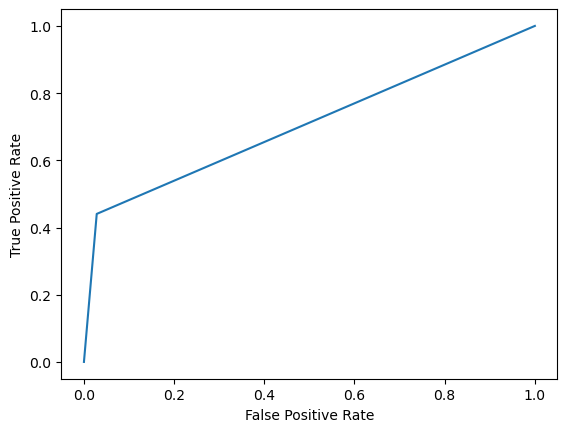

In [29]:
#ROC Curve LINEAR LR

fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred)
auc = metrics.roc_auc_score(y_val, y_pred)


print("AUC for our data is LINEAR LR : ",auc)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
# C-param changed and C-param is inversely propotional to accuracy
clf = LogisticRegression(solver='liblinear', max_iter=1000, C=0.5)
clf.fit(X_train, y_train)


LogisticRegression(C=0.5, max_iter=1000, solver='liblinear')

In [31]:
print(f'LR with C= 0.5 Training accuracy: {clf.score(X_train, y_train):0.4f}')

LR with C= 0.5 Training accuracy: 0.9025


In [32]:
1 - y_train.sum() / y_train.shape[0]

0.8598074608904933

In [33]:
X_val = scaler.transform(X_val)
X_val = imputer.transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced accuracy (train): 0.7211


In [34]:
print('LR with C = 0.5 Classification Report\n')
print(classification_report(y_val, y_pred))

LR with C = 0.5 Classification Report

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      3949
         1.0       0.70      0.47      0.57       622

    accuracy                           0.90      4571
   macro avg       0.81      0.72      0.75      4571
weighted avg       0.89      0.90      0.89      4571



In [35]:
clf = SVC(C=0.1, kernel='linear', gamma= 1)
clf.fit(X_train, y_train)

SVC(C=0.1, gamma=1, kernel='linear')

In [36]:
print(f'SVM Training accuracy for C = 0.1 : {clf.score(X_train, y_train):0.4f}')

SVM Training accuracy for C = 0.1 : 0.9003


In [37]:
1 - y_train.sum() / y_train.shape[0]

0.8598074608904933

In [38]:
X_val = scaler.transform(X_val)
X_val = imputer.transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced accuracy (train): 0.6693


In [39]:
print('SVM with linear kernel Classification Report\n')
print(classification_report(y_val, y_pred))

SVM with linear kernel Classification Report

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      3949
         1.0       0.74      0.36      0.48       622

    accuracy                           0.90      4571
   macro avg       0.82      0.67      0.71      4571
weighted avg       0.88      0.90      0.88      4571



In [40]:
clf = SVC(C= .1, kernel='sigmoid', gamma= 1)
clf.fit(X_train, y_train)

SVC(C=0.1, gamma=1, kernel='sigmoid')

In [41]:
print(f'Training accuracy: {clf.score(X_train, y_train):0.4f}')

Training accuracy: 0.7851


In [42]:
1 - y_train.sum() / y_train.shape[0]

0.8598074608904933

In [43]:
X_val = scaler.transform(X_val)
X_val = imputer.transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced accuracy (train): 0.5706


In [44]:
print('SVM with sigmoid kernel Classification Report\n')
print(classification_report(y_val, y_pred))

SVM with sigmoid kernel Classification Report

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90      3949
         1.0       0.31      0.22      0.26       622

    accuracy                           0.83      4571
   macro avg       0.60      0.57      0.58      4571
weighted avg       0.80      0.83      0.82      4571



AUC for our data is SIGMOID KERNEL :  0.5706190423071005


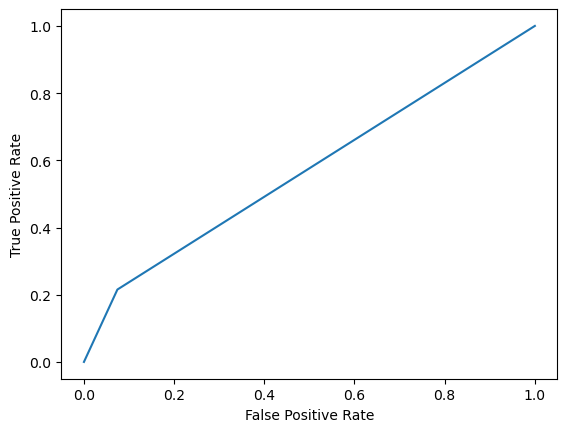

In [45]:
#ROC Curve SIGMOID KERNEL

fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred)
auc = metrics.roc_auc_score(y_val, y_pred)


print("AUC for our data is SIGMOID KERNEL : ",auc)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()